In [2]:
TOKEN_NEPTUNE = 'INSERTHERETOKEN'
KEY_NAME = 'P1-Facial-Keypoints'

XAVIER_INITIATION = True
SAVE_MODEL = True
USE_NEPTUNE = True

IMAGE_SIZE = 224
BATCH_SIZE = 256
EARLY_STOPING = 20
N_EPOCHS = 1000

import os
if not os.path.exists('aux'): os.makedirs('aux')
if not os.path.exists('saved_models'):os.makedirs('saved_models')

# Initial Setup

In [3]:
import torch as torch
import torch.optim as optim
import torch.nn as nn
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torchvision
import scipy
import seaborn as sns

!pip install --quiet neptune-client neptune-contrib
import neptune.new as neptune

print('torch>=',torch.__version__, sep='')
print('opencv-python==',cv2.__version__, sep='')
print('matplotlib==',matplotlib.__version__, sep='')
print('pandas==',pd.__version__, sep='')
print('numpy==',np.__version__, sep='')
print('torchvision==',torchvision.__version__, sep='')
print('scipy==',scipy.__version__, sep='')
print('neptune==',neptune.__version__, sep='')
print('seaborn==',sns.__version__, sep='')

     |████████████████████████████████| 245kB 8.1MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 829kB 28.3MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 174kB 36.2MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 
     |████████████████████████████████| 133kB 36.1MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
torch>=1.8.1+cu101
opencv-python==4.1.2
matplotlib==3.2.2
pandas==1.1.5
numpy==1.19.5
torchvision==0.9.1+cu101
scipy==1.4.1
neptune==0.9.16
seaborn==0.11.1


In [4]:
from models import Net_V1_0, Net_V1_1, Net_V1_2, Net_V1_3 
import torch as torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
net = None

# cleaning functions and supervision functions of GPU free memory
if DEVICE == 'cuda':
    import gc
    def clean_object_from_memory(obj): #definition
        del obj
        gc.collect()

    def clean_cuda_memory(): #definition    
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        
    #this means I'm in Collab
    if os.getcwd() == '/content': 
        !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
        !pip install gputil
        !pip install psutil
        !pip install humanize
        from workspace_utils import checkFreeGPU
        checkFreeGPU()
DEVICE

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=84e0e80ac2fc05042d07a19a2bbbeba5ec6cd705bf11d2419a0d1b040b82d031
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.6 GB  |     Proc size: 345.3 MB
GPU RAM Free: 16278MB | Used: 2MB | Util   0% | Total     16280MB


'cuda'

In [5]:
# import the usual resources
import matplotlib.pyplot as plt

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

# Data Load and Definition

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(int(IMAGE_SIZE*1.1)), RandomCrop(IMAGE_SIZE), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)
#transformed_dataset.to(DEVICE)

print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

# load training data in batches
train_loader = DataLoader(transformed_dataset,  batch_size=BATCH_SIZE, shuffle=True,  pin_memory=True)
                          #num_workers=2) #changed from 4

# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv', root_dir='data/test/', transform=data_transform)

# load test data in batches
#test_dataset.to(DEVICE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True,  pin_memory=True)
                         #num_workers=2) #changed from 4

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [7]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [8]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    test_images = test_images.to('cpu')
    test_outputs = test_outputs.to('cpu')

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()

# Run

## Training Function

In [9]:
def checkEarlyStoping(validList, EARLYSTOPPING):
    validList = validList[-EARLYSTOPPING:]
    if len(validList) < EARLYSTOPPING: return False
    elif validList[0] == min(validList): return True
    return False

def train_net(n_epochs, model, criterion, optimizer):
    from time import time
    start = time()
    # prepare the net for training
    model.to(DEVICE)
    model.train()
    running_train_loss = [[] for _ in range(n_epochs)]
    running_val_loss = [[] for _ in range(n_epochs)]
    running_val_epochs_loss, running_train_epochs_loss = [], []
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            #print('batch', batch_i, '-', batch_i % 10)
            # get the input images and their corresponding labels
            images = data['image']
            images = images.type(torch.FloatTensor)
            
            # convert variables to floats for regression loss
            key_pts = data['keypoints']
            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            key_pts = key_pts.type(torch.FloatTensor)

            if DEVICE == 'cuda': images, key_pts = images.cuda(), key_pts.to(DEVICE)
            
            # forward pass to get outputs
            output_pts = model(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            running_train_loss[epoch].append(loss.item())
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            if batch_i % 10 == 9:    # print every 10 batches
                print(f'\rEpoch: {epoch + 1:>4}, Batch: {batch_i+1:>4}, Cur. Loss: {round(running_train_loss[epoch][-1], 5):>7}, Avg. Loss: {round(np.mean(running_train_loss[epoch]), 5):>7}', end='')
            
        model.eval()
        
        with torch.no_grad():
            for data in test_loader:
            
                images, key_pts = data['image'].type(torch.FloatTensor),  data['keypoints'].type(torch.FloatTensor)
                if DEVICE == 'cuda' : 
                    images = images.cuda()
                    key_pts = key_pts.cuda()

                preds = model(images)
                preds = preds.view(preds.size()[0], 68, -1).type(torch.FloatTensor)
                if DEVICE == 'cuda' :  preds = preds.cuda()

                loss_mae, loss_sl1, loss_mse = nn.L1Loss(), nn.SmoothL1Loss(), nn.MSELoss()
                mae_loss, sl1_loss, mse_loss = loss_mae(preds, key_pts), loss_sl1(preds, key_pts), loss_mse(preds, key_pts)
                running_val_loss[epoch].append([mae_loss.item(), sl1_loss.item(), mse_loss.item()])


            avg_mae = np.mean(np.array(running_val_loss[epoch])[:,0])
            avg_mae_s = np.mean(np.array(running_val_loss[epoch])[:,1])
            avg_mse = np.mean(np.array(running_val_loss[epoch])[:,2])
            running_val_epochs_loss.append([avg_mae, avg_mae_s, avg_mse])
            running_train_epochs_loss.append(np.mean(running_train_loss[epoch]))

            print(f' val-loss: {round(avg_mae, 3):<5}(MAE) {round(avg_mae_s, 3):<5}(MAE-Smooth) {round(avg_mse,3):<5}(MSE)')
              # notice '2' using MSE to measure earlystopp
            if checkEarlyStoping(np.array(running_val_epochs_loss)[:,2], EARLY_STOPING): 
                  duration = time() - start
                  print(f'EARLY STOPPING at {epoch} epoch, stopped learning in the past {EARLY_STOPING}, took {duration} seg')
                  if DEVICE == 'cuda': 
                      clean_object_from_memory(images)
                      clean_object_from_memory(key_pts)
                      clean_object_from_memory(preds)
                      clean_object_from_memory(model)
                      clean_cuda_memory()

                  return running_train_epochs_loss, running_val_epochs_loss, duration, model

    duration = time() - start
    print(f'Finished Training, total {n_epochs} epochs, took {duration} seg')
    if DEVICE == 'cuda': 
        clean_object_from_memory(images)
        clean_object_from_memory(key_pts)
        clean_object_from_memory(preds)
        clean_object_from_memory(model)
        clean_cuda_memory()
        clean_cuda_memory()
        
    return running_train_epochs_loss, running_val_epochs_loss, duration, model


## Run Trial

In [10]:
def runtrial(net):
    if DEVICE == 'cuda': net = net.cuda()
    print(net, file=open('model_definition.txt', 'w'))
    
    if USE_NEPTUNE:
        run = neptune.init(project='joao.d.oliveira/Computer-Vision-runs', api_token=TOKEN_NEPTUNE)
        run["parameters"] = {"learning_rate": LEARNING_RATE, "batch_size": BATCH_SIZE, "loss_function": LOSS, "optimizer": OPTIMIZER, "momentum": MOMENTUM, "n_epochs": N_EPOCHS, "run_name": RUN_KEY}
        run["artifacts/model_definition"].upload("model_definition.txt")

    # 0 - MAE; 1 - MAE_smooth; 2 - MSE
    if LOSS == 0: criterion = nn.L1Loss() 
    else: criterion = nn.SmoothL1Loss() if LOSS == 1 else nn.MSELoss()
    # 0 - Adam; 1 - SGD
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, betas=MOMENTUM) if OPTIMIZER == 0 else optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9)
    # train your network

    running_train_loss, running_val_loss, duration, net = train_net(N_EPOCHS, net, criterion, optimizer)

    if SAVE_MODEL: 
        filename = "".join([c for c in RUN_KEY if c not in '( ,:).'])
        torch.save(net.state_dict(), f'saved_models/model_{filename}.pt')

    if USE_NEPTUNE:
        run['duration'] = duration

        for epoch in range(len(running_train_loss)): 
            run["metrics/train/loss"].log(running_train_loss[epoch])
            run['metrics/test/MAE'].log(running_val_loss[epoch][0])
            run['metrics/test/MAE-Smooth'].log(running_val_loss[epoch][1])
            run['metrics/test/MSE'].log(running_val_loss[epoch][2])

        if SAVE_MODEL:
            run["artifacts/model_trained"].upload(f'saved_models/model_{filename}.pt')

    run.stop()
    
    if DEVICE == 'cuda': clean_object_from_memory(net)        
    return net

## Print Model Structure

In [11]:
from torchsummary import summary
import sys
    
k = sys.stdout
sys.stdout = open('aux/model_summary_1_0.txt', 'w')
summary(Net_V1_0(), (1, 224, 224), 10, device='cpu')

sys.stdout = open('aux/model_summary_1_1.txt', 'w')
summary(Net_V1_1(), (1, 224, 224), 10, device='cpu')

sys.stdout = open('aux/model_summary_1_2.txt', 'w')
summary(Net_V1_2(), (1, 224, 224), 10, device='cpu')

sys.stdout = open('aux/model_summary_1_3.txt', 'w')
summary(Net_V1_3(), (1, 224, 224), 10, device='cpu')

sys.stdout = k

## Main Function - Run trial(s)

In [12]:
run_param = []

for lrate in [0.0001, 0.001, 0.01]:
    for lo in range(3): # 0 - MAE; 1 - MAE_smooth; 2 - MSE
        for op in range(2): # 0 - Adam; 1 - SGD
            for m in [(0.9, 0.999), (0.85, 0.999), (0.85, 0.95), (0.8, 0.9), 0.9, 0.8, 0.85]: 
                # tuple Adam (0.9, 0.999); number SGD 0.9
                if (op == 1 and type(m) == tuple) or (op == 0 and type(m) != tuple): continue
                for mod in range(4): # choose which model to load
                    run_param.append([m, op, lo, lrate, mod])

In [13]:
# check free GPU memory (make sure there's nothing lingering) before runing trials
if DEVICE == 'cuda' and os.getcwd() == '/content': checkFreeGPU()

Gen RAM Free: 12.6 GB  |     Proc size: 1.9 GB
GPU RAM Free: 16278MB | Used: 2MB | Util   0% | Total     16280MB


In [14]:
#for param in run_param: #run with a batch of runs with certain parames
for param in [[(0.85, 0.95), 0, 0, 0.0001, 0]]: #run a single run  
    MOMENTUM, OPTIMIZER, LOSS, LEARNING_RATE, mod_v = param
    VERSION = f"v1.{mod_v}.0"
    SPECIFIC_RUN = f'Initiation:{XAVIER_INITIATION}-Batch:{BATCH_SIZE}-LR:{LEARNING_RATE}-Loss:{LOSS}-Opti:{OPTIMIZER}-Mom:{MOMENTUM}'
    RUN_KEY = "_".join([VERSION, SPECIFIC_RUN]) + '_'
    if mod_v == 0: m = Net_V1_0(initiation=XAVIER_INITIATION)
    elif mod_v == 1: m = Net_V1_1(initiation=XAVIER_INITIATION)
    elif mod_v == 2: m = Net_V1_2(initiation=XAVIER_INITIATION)
    else: m = Net_V1_3(initiation=XAVIER_INITIATION)
    print(RUN_KEY)
    net =  runtrial(m)
    if DEVICE == 'cuda': clean_cuda_memory()

v1.0.0_Initiation:True-Batch:256-LR:0.0001-Loss:0-Opti:0-Mom:(0.85, 0.95)_
https://app.neptune.ai/joao.d.oliveira/computer-vision-runs/e/COM1-47
Epoch:    1, Batch:   10, Cur. Loss: 0.40231, Avg. Loss: 0.45511 val-loss: 0.513(MAE) 0.196(MAE-Smooth) 0.41 (MSE)
Epoch:    2, Batch:   10, Cur. Loss: 0.36322, Avg. Loss:  0.4185 val-loss: 0.309(MAE) 0.08 (MAE-Smooth) 0.165(MSE)
Epoch:    3, Batch:   10, Cur. Loss: 0.32471, Avg. Loss: 0.32817 val-loss: 0.37 (MAE) 0.124(MAE-Smooth) 0.255(MSE)
Epoch:    4, Batch:   10, Cur. Loss: 0.33383, Avg. Loss: 0.32347 val-loss: 0.307(MAE) 0.078(MAE-Smooth) 0.159(MSE)
Epoch:    5, Batch:   10, Cur. Loss:  0.3058, Avg. Loss: 0.32057 val-loss: 0.3  (MAE) 0.076(MAE-Smooth) 0.155(MSE)
Epoch:    6, Batch:   10, Cur. Loss: 0.32027, Avg. Loss: 0.31669 val-loss: 0.263(MAE) 0.063(MAE-Smooth) 0.131(MSE)
Epoch:    7, Batch:   10, Cur. Loss: 0.29786, Avg. Loss: 0.30298 val-loss: 0.314(MAE) 0.096(MAE-Smooth) 0.203(MSE)
Epoch:    8, Batch:   10, Cur. Loss: 0.30367, Avg.

Waiting for the remaining 370 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 363 operations (1.89% done). Please wait.


All 370 operations synced, thanks for waiting!


# Questions and Feature Visualization

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 

Before experimenting, my intuition would be to use *Adam* with a *LR (0.001 or 0.0001)* and use *MSE* as a Loss function.

After doing experiences I've confirmed that *Adam* has a clear advantage over *SGD*. I also saw improvement in choosing MSE versus other functions (however not as steep as Adam vs SGD)

The reason I believe Adam works better, is due to the fact that it uses separate learning rates for each of the parameters.
SGD as far as I studyed can be tweeaked using Nesterov Momentum, and other types of betas to even outperform Adam, but I haven't tested it for this case.
Link to article: [comparisation Adam vs SGD](https://medium.com/@Biboswan98/optim-adam-vs-optim-sgd-lets-dive-in-8dbf1890fbdc)

From my experience *MSE* is more agressive as a loss function due to the fact that is is quadratic (mean square error) so more punishing in the errors. That is why it's the one I normally use, and as per the experiences, it proved to be better than the others (however not as significant as I would expect).

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 

I already started with a *complex* structure (following the article about [AlexNet](https://medium.com/@smallfishbigsea/a-walk-through-of-alexnet-6cbd137a5637)).<br>
So for extracting the features from the image I used **4 conv2D** (all with ReLu after MaxPool layers) and with **3 Dropout layers** (only didn't put one in the first Conv2D since I read that it could impact negatively the model due to limiting it's potential). For the **regressor/output** I initially used **2 Linear layers** (the input of the features and the output layer).

Then I created a **2nd model**, with the intent to optimize the **"regressor"** with one extra layer on the regressor part of the model, making it **3 Linear Layers**.
This was an apparent improvement vs the 1st, however with an **heavy** cost on memory (parameters: *+1GB*), and more prone to overfitting. In terms of validation with longer runs (± 60 epochs), it proved not to be more efficient than the more simplified version (1st model).

Following these findings, I wondered what could be the impact of simplifying the model, so I created the **3rd and 4th model** with **3 and 2 Conv2D** to extract the features (respectively) and **2 Linear Layers** for the **regressor**.

These simplified models not only behaved better than I expected, but even better than the heaviest model (2nd) which means that I was clearly creating noise in the **2nd model** with extra layers.

Neverthless, **the one that proved to be the best in terms of memory, speed, results and not overfitting, was the 1st model (model v1.0.0)**

Also noticed that **Xavier Activation** made it better in terms of speed and performance of training.


### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: 

For the epochs, I usually start small, to find the right parameters (optimizers, loss functions, hyper-parameters), and then prefer to use a big number of epochs, however always accompanied by checking for early stopping to avoid overfitting.

In practice, that means, I started with **20 epochs** for testing the models, optimizers, loss functions, parameters, ... then once I was confortable I had the right optimizer, model, ... combination, I increased to **1,000 epochs** training,  however with a **early stop of 20 epochs**.

Initiation helped the model to go a bit forward and have a slight improvement on performance, in my intuition by making it less prune to jumps.

In terms of **batch_size** I decided to go for the initial **10 samples**, given that with GPU it didn't turn out so slow (despite the number of batches) and was for sure lighter in memory given the batches of images were smaller (since we are training images).<br>
I tried to increase it to **100 batch size** had slight impact on the duration(but not much, since you gain with less batch but you increase the memory heavily given it's pictures), and a negative impact compared with the **10 samples** (up to ±15% of MSE loss sometimes)


Notice though that for my heaviest models (v1.0.0 and v1.1.0) the maximum was around **256 batch size**, otherwise was too heavy for GPU.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

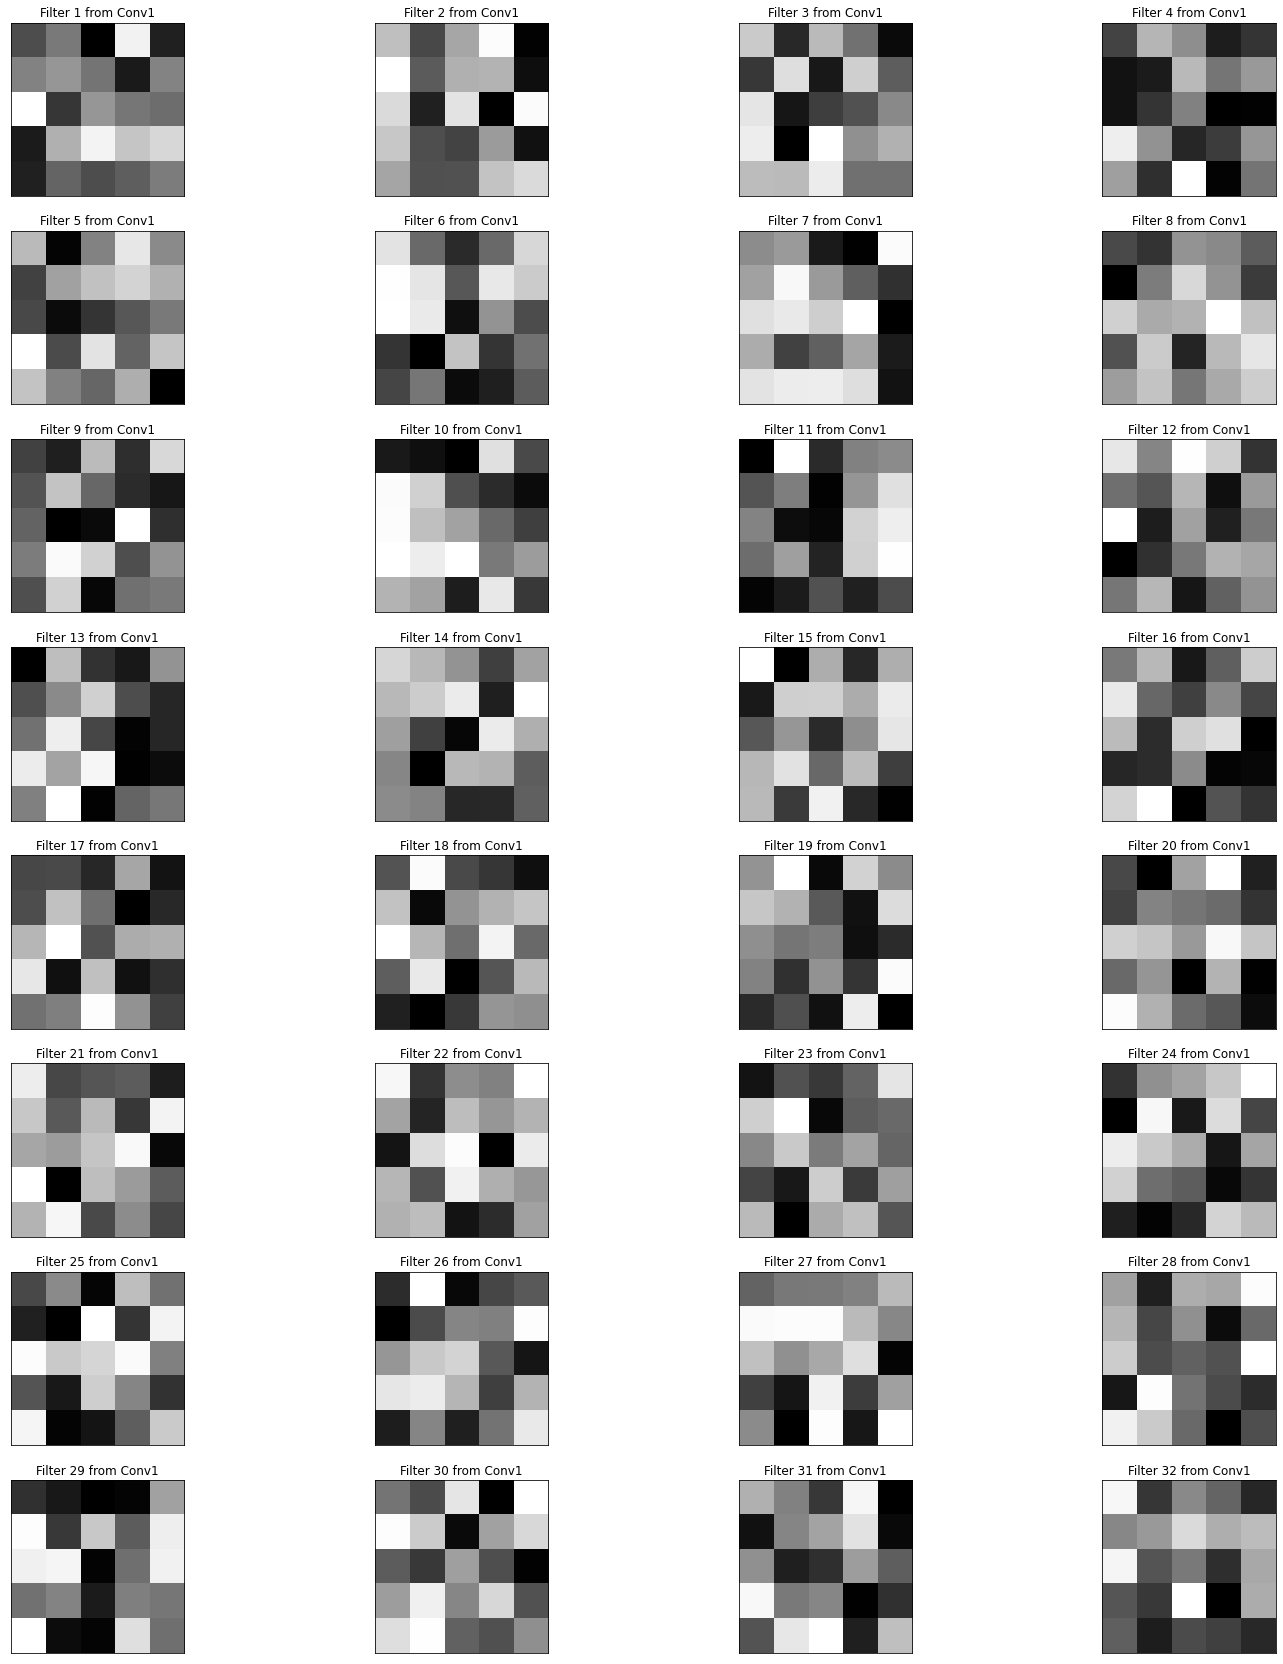

In [15]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer

# if net == None means there wasn't any run yet, so load trained model
if net == None:
  net = Net_V1_3(True)
  model_name = 'model_v130_InitiationTrue-Batch10-LR00001-Loss0-Opti0-Mom085095_.pt'
  net.load_state_dict(torch.load(f'saved_models/{model_name}',
                                map_location=torch.device('cpu')))

weights1 = net.features.conv1.weight.data
if DEVICE == 'cuda': weights1 = weights1.cpu()

w = weights1.numpy()

# display the filter weights
fig = plt.figure(figsize=(25, 30))
for idx in range(weights1.shape[0]):
    ax = fig.add_subplot(8, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(w[idx][0], cmap='gray') 
    ax.set_title(f"Filter {idx+1} from Conv1")

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

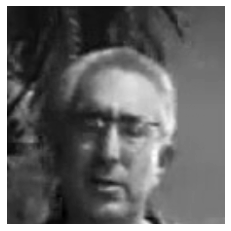

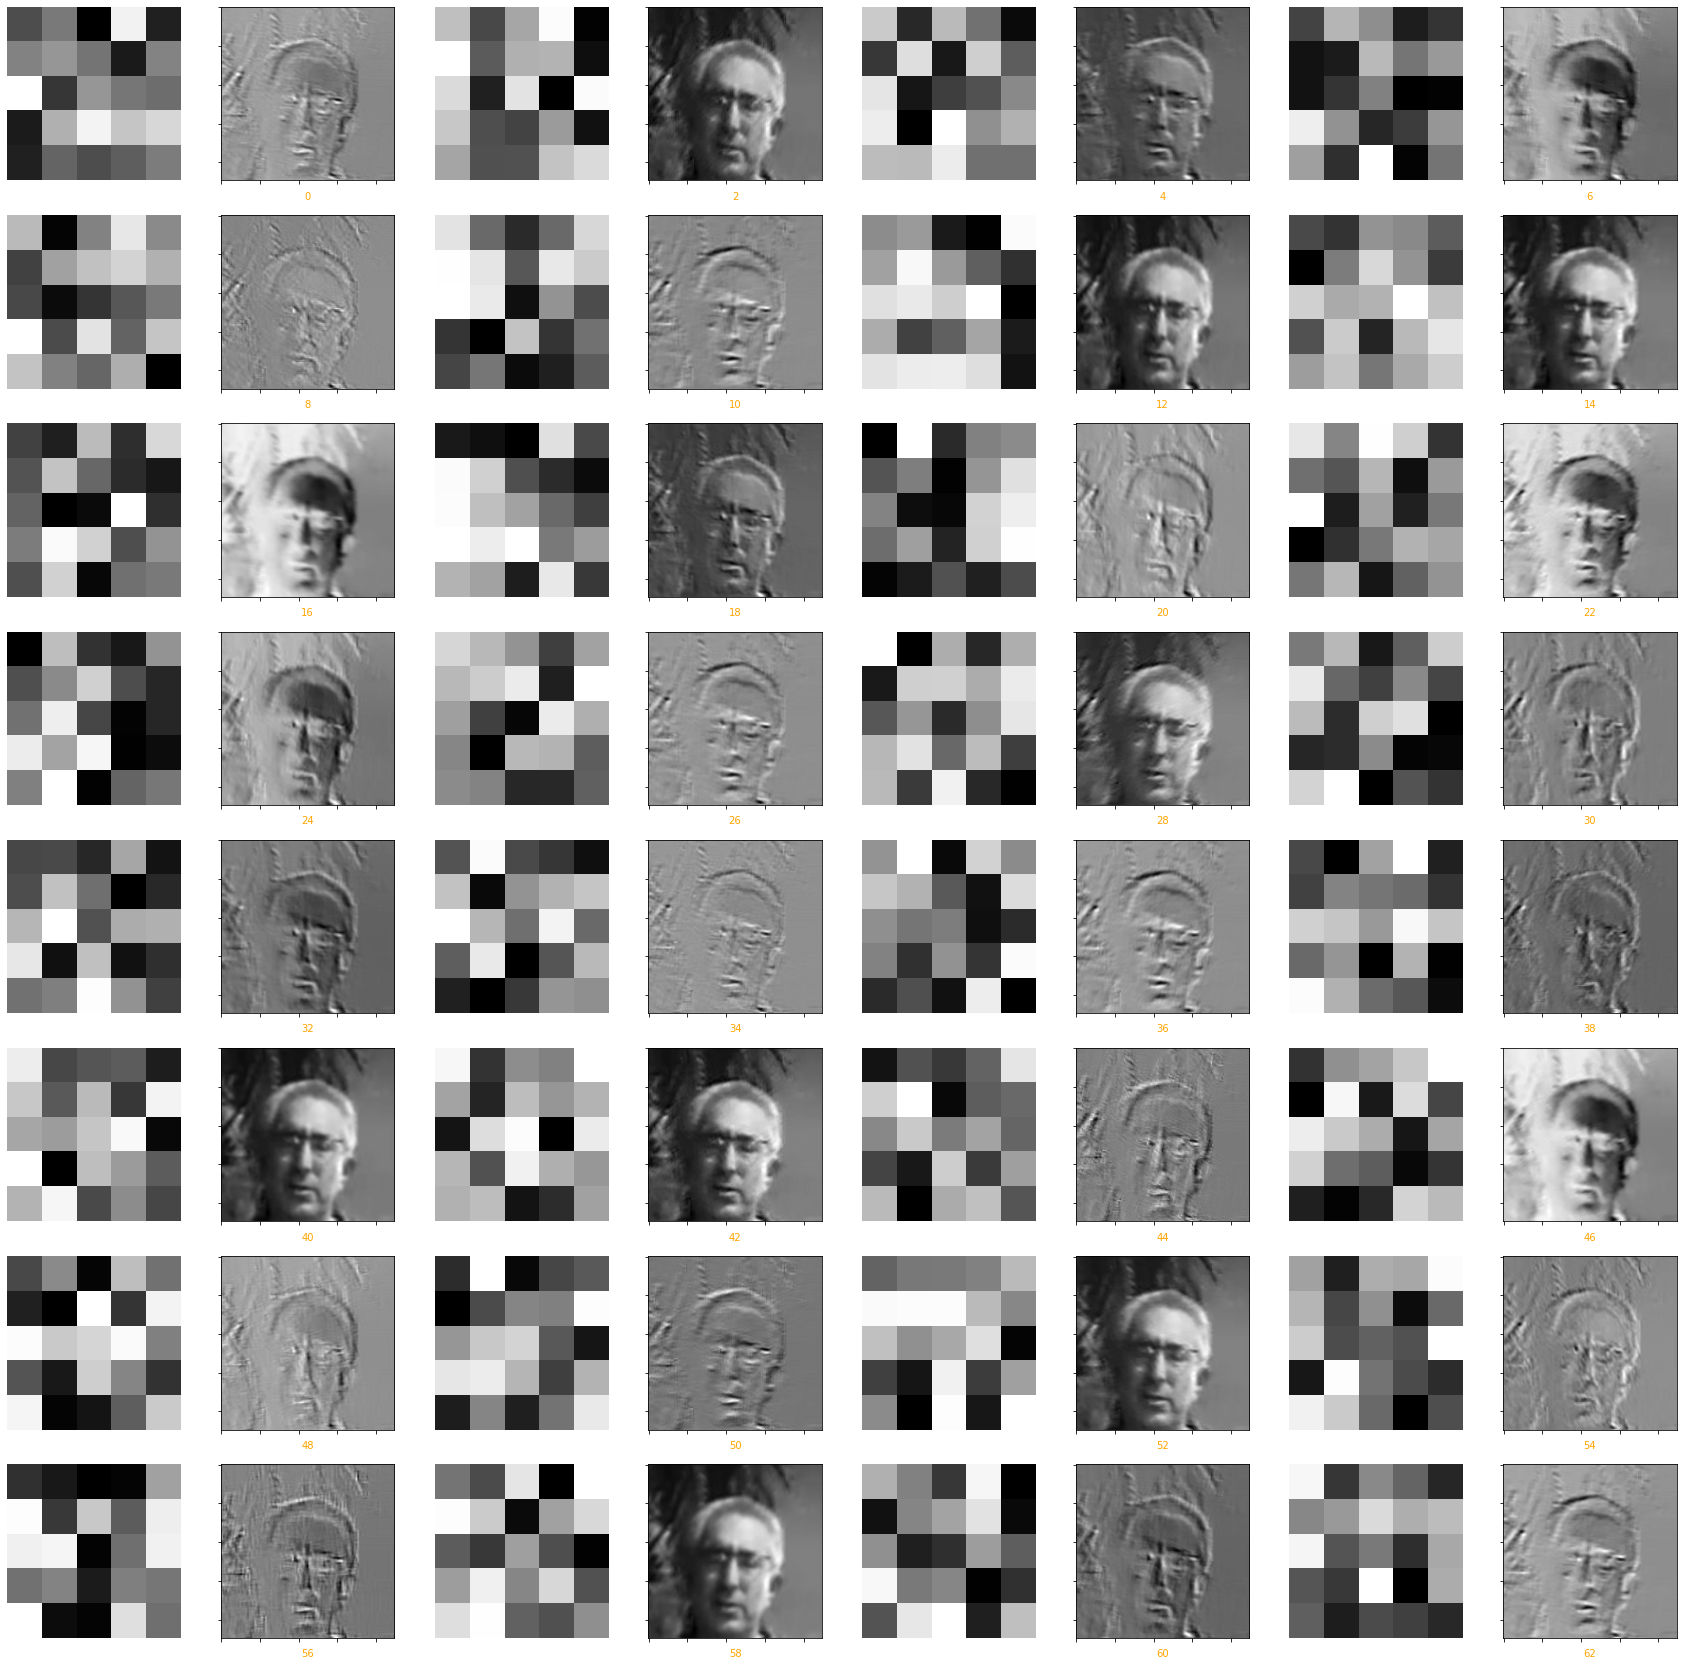

In [16]:
##TODO: load in and display any image from the transformed test dataset
sample = iter(test_loader).next()
test_images = sample['image']

selected_img = np.squeeze(test_images[0][0]).numpy()
plt.imshow(test_images[0][0], cmap='gray')
plt.grid(False)
plt.axis('off')
fig=plt.figure(figsize=(30, 30))

row, col = 8, 8
for idx in range(0, row*col, 2):
    fig.add_subplot(row, col, idx + 1)
    plt.imshow(w[idx // 2][0], cmap='gray')
    plt.axis('off')
    fig.add_subplot(row, col, idx + 2)
    c = cv2.filter2D(selected_img, -1, w[idx // 2][0])
    ax = plt.imshow(c, cmap='gray')
    
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.grid(False)
    plt.xlabel(idx, color='orange')
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: 

I displayed above all the 32 filters from the first convoluted layer.

You can see clearly that the model makes a combination of multiple filters (from corners highlight to blur).
Example: 
* Picture 6 highlights corners that come from left to right
* Picture 40 gives us the diagonal cornes
* Picture 52,8 howver gives us a blur

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!